In [86]:
import pandas as pd

from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, recall_score, balanced_accuracy_score, f1_score, precision_score
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures

from imblearn.over_sampling import SMOTE,RandomOverSampler
from imblearn.pipeline import make_pipeline

In [51]:
df = pd.read_csv('../../Data/Merged_Data/final_data.csv.zip')
df_with_sponsors = pd.read_csv('../../Data/Merged_Data/final_data_with_sponsors.csv.zip')

# Splitting Data into Train and Test 

In [168]:
X = df[['title', 'gov_party','senate_party','house_party','state_party_control','party_of_1st_chamber','party_of_2nd_chamber']]
y = df['law_enacted']


X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 42, stratify = y)

# Metrics Function

In [54]:
def my_metrics(estimator, X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test):
    
    train_preds = estimator.predict(X_train)
    preds = estimator.predict(X_test)
    
    train_acc = accuracy_score(y_train, train_preds)
    train_recall = recall_score(y_train, train_preds)
    test_acc = accuracy_score(y_test, preds)
    recall = recall_score(y_test, preds)
    precision = precision_score(y_test, preds)
    
    print(f'Train Accuracy: {train_acc}')
    print(f'Train Recall: {train_recall}')
    print(f'Test Accuracy: {test_acc}')
    print(f'Test Recall: {recall}')
    print(f'Test Precision: {precision}')
    print()
    print(f'Test Confusion Matrix:')
    
    ConfusionMatrixDisplay.from_estimator(estimator, X_test, y_test)
    
    return {
        'accuracy': test_acc,
        'recall': recall,
        'precision': precision
    }


In [76]:
#List that will keep track of metrics
history = []

In [167]:
#For column transformers later
word_feature = 'title'
party_features = ['gov_party','senate_party','house_party','state_party_control','party_of_1st_chamber','party_of_2nd_chamber']

# Baseline Model

This model is one that guesses that the bill will not pass for every bill.

In [57]:
df['law_enacted'].value_counts(normalize = True)

0    0.796322
1    0.203678
Name: law_enacted, dtype: float64

This model has 79.6% accuracy

# CV with Simple with Default Random Forest
Strategy: First model will be kept simple:

    -CountVectorize title but only keep 200 features
    -OneHotEncode categorical variables
    -Random Forest

Train Accuracy: 0.9698970456580125
Train Recall: 0.8829131310664795
Test Accuracy: 0.8272595024059085
Test Recall: 0.42747252747252745
Test Precision: 0.6079708257358687

Test Confusion Matrix:


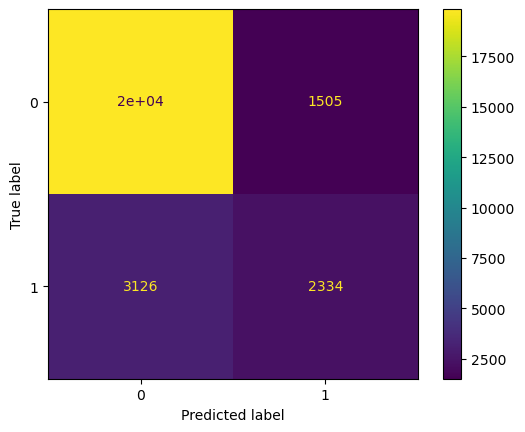

In [58]:
#Pipeline for our title feature: Count Vectorize it
word_pipe = Pipeline([
    ('cv', CountVectorizer(stop_words='english', max_features=2000))
])

#Pipeline for the party features: One Hot encode them
party_pipe = Pipeline([
    ('ohe', OneHotEncoder(drop= 'first'))
])

#Column transformer that will transform our whole dataframe
preprocess = ColumnTransformer([
    ('cvec', word_pipe, word_feature),
    ('party', party_pipe, party_features)
])

#Estimator pipeline with our preprocessing in there
rf_pipe = Pipeline([
    ('pre', preprocess),
    ('rf', RandomForestClassifier(random_state = 42))
])

rf_pipe.fit(X_train, y_train)

history.append(my_metrics(rf_pipe));

This model is definetly overfit. But shows much better promise than the Logistic Regression. The accuracy, recall and precision are all fairly high! Let's see if we can correct the overfitness with some hyperparameter tuning.

# CV with Random Forest and different hyperparameters

It would be better to just gridsearch cv over many hyper parameter combinations. But this will be too computationally expensive and thus I am manually going trhough the hyperparam combos.

## Max_Depth = 150 & n_estimator = 20
Strategy:

    -CountVectorize title and only keep the 2000 most used words
    -OneHotEncode categorical variables
    -Random Forest Classifier with some tuned parameters
        -Max_Depth = 150 & n_estimator = 20 :
            - the maximum depth of the tree and the amount of decision trees used in the forest
            - Hopefully these help with the overfitting seen above

Train Accuracy: 0.9316621903909281
Train Recall: 0.6824980159941395
Test Accuracy: 0.8360625163191465
Test Recall: 0.3547619047619048
Test Precision: 0.6895692417230331

Test Confusion Matrix:


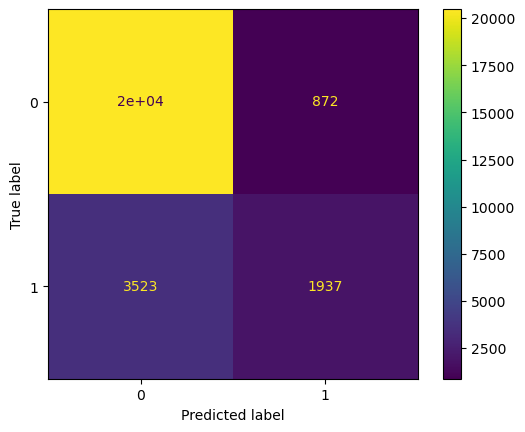

In [77]:
#Pipeline for our title feature: Count Vectorize it
word_pipe = Pipeline([
    ('cv', CountVectorizer(stop_words='english', max_features=2000))
])

#Pipeline for the party features: One Hot encode them
party_pipe = Pipeline([
    ('ohe', OneHotEncoder(drop= 'first'))
])

#Column transformer that will transform our whole dataframe
preprocess = ColumnTransformer([
    ('cvec', word_pipe, word_feature),
    ('party', party_pipe, party_features)
])

#Estimator pipeline with our preprocessing in there
rf_pipe_params1 = Pipeline([
    ('pre', preprocess),
    ('rf', RandomForestClassifier(random_state = 42, max_depth = 150,n_estimators = 20))
])

rf_pipe_params1.fit(X_train, y_train)

history.append(my_metrics(rf_pipe_params1));

In [78]:
pd.DataFrame(history, index = ['rf', 'rf_hyperparams_tuned'])

,accuracy,recall,precision
rf,0.827260,0.427473,0.607971
rf_hyperparams_tuned,0.836063,0.354762,0.689569


Better test accuracy, worse recall. Still overfit, more tuning needed.

## Max_Depth = 70 & n_estimator = 30
Strategy:

    -CountVectorize title and only keep the 2000 most used words
    -OneHotEncode categorical variables
    -Random Forest Classifier with some tuned parameters
        -Max_Depth = 70 & n_estimator = 30 :
            - Hopefully these help with the overfitting seen above

Train Accuracy: 0.8807072515666965
Train Recall: 0.42659178316342106
Test Accuracy: 0.8377783580140997
Test Recall: 0.2934065934065934
Test Precision: 0.7654085045389393

Test Confusion Matrix:


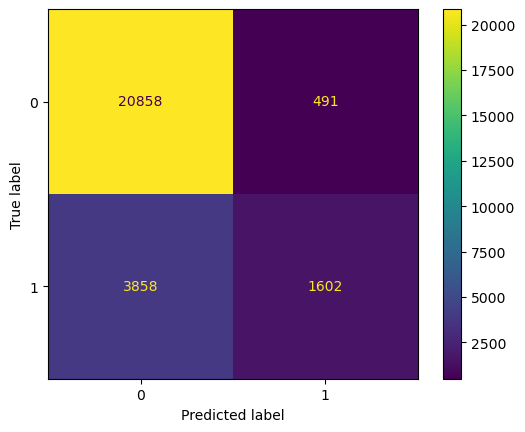

In [79]:
#Pipeline for our title feature: Count Vectorize it
word_pipe = Pipeline([
    ('cv', CountVectorizer(stop_words='english', max_features=2000))
])

#Pipeline for the party features: One Hot encode them
party_pipe = Pipeline([
    ('ohe', OneHotEncoder(drop= 'first'))
])

#Column transformer that will transform our whole dataframe
preprocess = ColumnTransformer([
    ('cvec', word_pipe, word_feature),
    ('party', party_pipe, party_features)
])

#Estimator pipeline with our preprocessing in there
rf_pipe_params2 = Pipeline([
    ('pre', preprocess),
    ('rf', RandomForestClassifier(random_state = 42, max_depth = 70,n_estimators = 30))
])

rf_pipe_params2.fit(X_train, y_train)

history.append(my_metrics(rf_pipe_params2));

In [80]:
pd.DataFrame(history, index = ['rf', 'rf_hyperparams_overfit', 'rf_hyperparams_better'])

,accuracy,recall,precision
rf,0.827260,0.427473,0.607971
rf_hyperparams_overfit,0.836063,0.354762,0.689569
rf_hyperparams_better,0.837778,0.293407,0.765409


Less overfit now, best accuracy yet, lowest recall though. Great precision. Very hard to predict the imbalance classes though.

## Max_Depth = 70 & n_estimator = 30 & min_samples_leaf = 7:
Strategy:

    -CountVectorize title and only keep the 2000 most used words
    -OneHotEncode categorical variables
    -Random Forest Classifier with some tuned parameters
        -Max_Depth = 70 & n_estimator = 30 & min_samples_leaf = 7:
            - min sample leaf refers to the minimum amount of samples required to be in a leaf node

Train Accuracy: 0.8306724360887298
Train Recall: 0.2066418411574385
Test Accuracy: 0.829460255884218
Test Recall: 0.21208791208791208
Test Precision: 0.8109243697478992

Test Confusion Matrix:


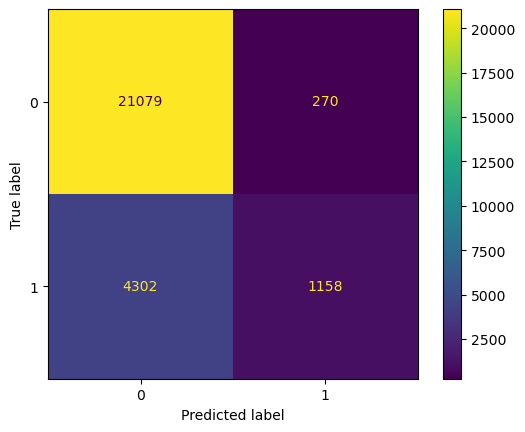

In [81]:
#Pipeline for our title feature: Count Vectorize it
word_pipe = Pipeline([
    ('cv', CountVectorizer(stop_words='english', max_features=2000))
])

#Pipeline for the party features: One Hot encode them
party_pipe = Pipeline([
    ('ohe', OneHotEncoder(drop= 'first'))
])

#Column transformer that will transform our whole dataframe
preprocess = ColumnTransformer([
    ('cvec', word_pipe, word_feature),
    ('party', party_pipe, party_features)
])

#Estimator pipeline with our preprocessing in there
rf_pipe_min_leaf = Pipeline([
    ('pre', preprocess),
    ('rf', RandomForestClassifier(random_state = 42, max_depth = 70,n_estimators = 30, min_samples_leaf = 7))
])

rf_pipe_min_leaf.fit(X_train, y_train)

history.append(my_metrics(rf_pipe_min_leaf));

In [82]:
pd.DataFrame(history, index = ['rf', 'rf_hyperparams_overfit', 'rf_hyperparams_better', 'rf_hyperparams_sample_leaf'])

,accuracy,recall,precision
rf,0.827260,0.427473,0.607971
rf_hyperparams_overfit,0.836063,0.354762,0.689569
rf_hyperparams_better,0.837778,0.293407,0.765409
rf_hyperparams_sample_leaf,0.829460,0.212088,0.810924


Sample leafs did not help.

## class_weight = 'balanced_subsample'
Strategy:

    -CountVectorize title and only keep the 2000 most used words
    -OneHotEncode categorical variables
    -Random Forest Classifier with some tuned parameters
        -Max_Depth = 70 & n_estimator = 30 & min_samples_leaf = 7, class_weight = 'balanced_subsample':
            - class_weight = 'balanced_subsample' gives a higher weaight to the undersampled calss
            - hopefully will help with the imbalanced classes

Train Accuracy: 0.7496021088232369
Train Recall: 0.7786459923081619
Test Accuracy: 0.7280763922563318
Test Recall: 0.7304029304029304
Test Precision: 0.4066897817662656

Test Confusion Matrix:


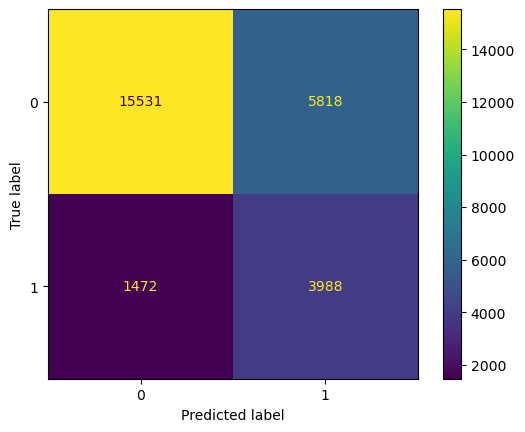

In [169]:
#Pipeline for our title feature: Count Vectorize it
word_pipe = Pipeline([
    ('cv', CountVectorizer(stop_words='english', max_features=2000))
])

#Pipeline for the party features: One Hot encode them
party_pipe = Pipeline([
    ('ohe', OneHotEncoder())
])

#Column transformer that will transform our whole dataframe
preprocess = ColumnTransformer([
    ('cvec', word_pipe, word_feature),
    ('party', party_pipe, party_features)
])

#Estimator pipeline with our preprocessing in there
rf_pipe_class_weight = Pipeline([
    ('pre', preprocess),
    ('rf', RandomForestClassifier(random_state = 42, max_depth = 70,n_estimators = 40, min_samples_leaf = 7, class_weight = 'balanced_subsample'))
])

rf_pipe_class_weight.fit(X_train, y_train)

history.append(my_metrics(rf_pipe_class_weight));

In [138]:
pd.DataFrame(history, index = ['rf', 'rf_hyperparams_overfit', 'rf_hyperparams_better', 'rf_hyperparams_sample_leaf', 'rf_hyperparams_balanced_subsamples'])

,accuracy,recall,precision
rf,0.827260,0.427473,0.607971
rf_hyperparams_overfit,0.836063,0.354762,0.689569
rf_hyperparams_better,0.837778,0.293407,0.765409
rf_hyperparams_sample_leaf,0.829460,0.212088,0.810924
rf_hyperparams_balanced_subsamples,0.725689,0.733883,0.404421


Great! Recall is through the roof! Accuracy is worse than our base model but we are able to identify 73% of the bills that pass. Only 40% of the ones we predict will pass actually do, but that is not too shaby.

# CV Random Forest with SMOTE

Train Accuracy: 0.7730403859544415
Train Recall: 0.6450155668152128
Test Accuracy: 0.7592226491103734
Test Recall: 0.6126373626373627
Test Precision: 0.435263500325309

Test Confusion Matrix:


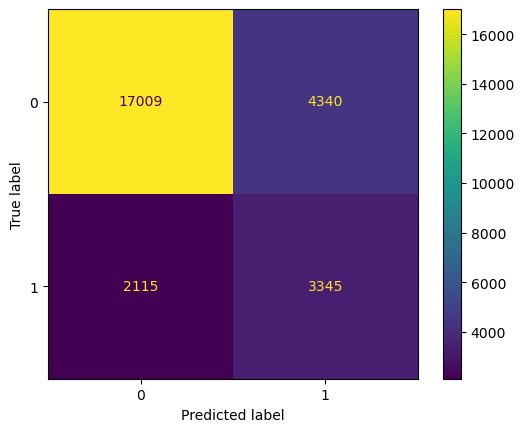

In [139]:
#Pipeline for our title feature: Count Vectorize it
word_pipe = Pipeline([
    ('cv', CountVectorizer(stop_words='english', max_features=2000))
])

#Pipeline for the party features: One Hot encode them
party_pipe = Pipeline([
    ('ohe', OneHotEncoder(drop= 'first'))
])

#Column transformer that will transform our whole dataframe
preprocess = ColumnTransformer([
    ('cvec', word_pipe, word_feature),
    ('party', party_pipe, party_features)
])

#Estimator pipeline with our preprocessing in there
rf_pipe_smote = make_pipeline(
    preprocess, 
    SMOTE(random_state = 42),
    RandomForestClassifier(random_state = 42, max_depth = 70,n_estimators = 40, min_samples_leaf = 7)
)

rf_pipe_smote.fit(X_train, y_train)

history.append(my_metrics(rf_pipe_smote));

In [140]:
pd.DataFrame(history, index = ['rf', 'rf_hyperparams_overfit', 'rf_hyperparams_better', 
                               'rf_hyperparams_sample_leaf', 'rf_hyperparams_balanced_subsamples',
                              'rf_SMOTE'])

,accuracy,recall,precision
rf,0.827260,0.427473,0.607971
rf_hyperparams_overfit,0.836063,0.354762,0.689569
rf_hyperparams_better,0.837778,0.293407,0.765409
rf_hyperparams_sample_leaf,0.829460,0.212088,0.810924
rf_hyperparams_balanced_subsamples,0.725689,0.733883,0.404421
rf_SMOTE,0.759223,0.612637,0.435264


SMOTE did not improve on our best model.

# Model on smaller data with extra column

In [141]:
X = df_with_sponsors[['title', 'gov_party','senate_party','house_party','state_party_control','party_of_1st_chamber','party_of_2nd_chamber', 'majority_sponsor_party']]
y = df_with_sponsors['law_enacted']


X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 42, stratify = y)
#For column transformers later
word_feature = 'title'
party_features = ['gov_party','senate_party','house_party','state_party_control','party_of_1st_chamber','party_of_2nd_chamber',  'majority_sponsor_party']

Train Accuracy: 0.7889963321107035
Train Recall: 0.7351512146752602
Test Accuracy: 0.7655218406135379
Test Recall: 0.6698393813206425
Test Precision: 0.4834693001288107

Test Confusion Matrix:


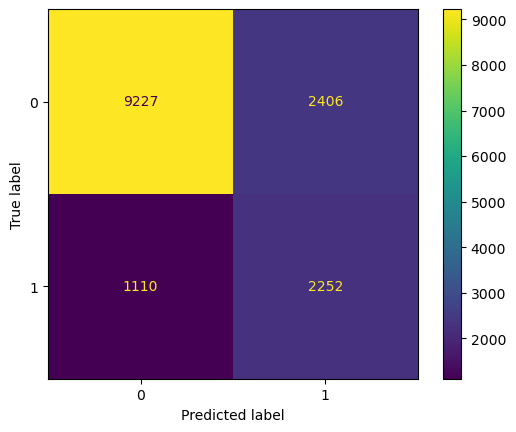

In [142]:
#Pipeline for our title feature: Count Vectorize it
word_pipe = Pipeline([
    ('cv', CountVectorizer(stop_words='english', max_features=2000))
])

#Pipeline for the party features: One Hot encode them
party_pipe = Pipeline([
    ('ohe', OneHotEncoder(drop= 'first')),
    ('poly', PolynomialFeatures())
])

#Column transformer that will transform our whole dataframe
preprocess = ColumnTransformer([
    ('cvec', word_pipe, word_feature),
    ('party', party_pipe, party_features)
])

#Estimator pipeline with our preprocessing in there
rf_pipe_smaller_df = Pipeline([
    ('pre', preprocess),
    ('rf', RandomForestClassifier(random_state = 42, max_depth = 70,n_estimators = 40, min_samples_leaf = 7, class_weight = 'balanced_subsample'))
])

rf_pipe_smaller_df.fit(X_train, y_train)

history.append(my_metrics(rf_pipe_smaller_df, X_train, X_test, y_train, y_test));

In [143]:
pd.DataFrame(history, index = ['rf', 'rf_hyperparams_overfit', 'rf_hyperparams_better', 
                               'rf_hyperparams_sample_leaf', 'rf_hyperparams_balanced_subsamples',
                              'rf_SMOTE', 'smaller_df'])

,accuracy,recall,precision
rf,0.827260,0.427473,0.607971
rf_hyperparams_overfit,0.836063,0.354762,0.689569
rf_hyperparams_better,0.837778,0.293407,0.765409
rf_hyperparams_sample_leaf,0.829460,0.212088,0.810924
rf_hyperparams_balanced_subsamples,0.725689,0.733883,0.404421
rf_SMOTE,0.759223,0.612637,0.435264
smaller_df,0.765522,0.669839,0.483469


# Inference from the best model

In [ ]:
rf_model = rf_pipe_class_weight.named_steps['model'].best_estimator_

feature_importances = rf_model.feature_importances_

In [152]:
feature_importance = rf_pipe_class_weight.named_steps['rf'].feature_importances_

In [153]:
coef_names = rf_pipe_class_weight.named_steps['pre'].get_feature_names_out()

In [158]:
feature_importance = dict(zip(coef_names, feature_importance))

In [165]:
sorted(feature_importance.items(), key = lambda x: x[1], reverse = True)

[('cvec__enacted', 0.07915645151137192),
 ('cvec__tech', 0.04401190161568813),
 ('cvec__introduced', 0.04392955105600865),
 ('cvec__relating', 0.029853202955402863),
 ('cvec__tca', 0.019855306560508386),
 ('cvec__bdr', 0.015002837465736451),
 ('cvec__title', 0.01396761858310543),
 ('cvec__revise', 0.012851205817572823),
 ('party__house_party_Rep', 0.012497942238372178),
 ('party__gov_party_Rep', 0.011649035524840711),
 ('cvec__requires', 0.011507807536390054),
 ('party__party_of_2nd_chamber_Rep', 0.011126503363967448),
 ('party__party_of_1st_chamber_Rep', 0.011071486011568868),
 ('party__senate_party_Rep', 0.01083783587709085),
 ('party__state_party_control_Split', 0.010626181995706922),
 ('cvec__amends', 0.010427098621007066),
 ('party__state_party_control_Rep', 0.009367179362051174),
 ('cvec__act', 0.009352557722350456),
 ('cvec__appropriated', 0.009316116024284237),
 ('cvec__revises', 0.008962529282445193),
 ('cvec__providing', 0.008806963821725732),
 ('cvec__modifies', 0.0080796539